Osnabrück University - Computer Vision (Winter Term 2018/19) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack, Axel Schaffland

# Exercise Sheet 06: Hough Transform

## Introduction

This week's sheet should be solved and handed in before the end of **Sunday, December 16, 2018**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (Eigenvectors and Eigenvalues) [0 Points]

This exercise is supposed to be very easy, does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What is an eigenvector of a matrix/a linear mapping? What are eigenvalues?

YOUR ANSWER HERE

**b)** What is the characteristic polynomial of a matrix? How is it related to eigenvalues? What are algebraic and geometric multiplicity of an eigenvalue?

YOUR ANSWER HERE

**c)** What is the spectrum of a matrix? What does the spectral theorem state?

YOUR ANSWER HERE

**d)** [bonus task]: Numpy/Scipy provide functions to compute eigenvalues. Lookup these functions and apply them to an example.

In [ ]:
# YOUR CODE HERE

## Assignment 1: Hough transform [6 Points]

**a)** Explain in your own words the idea of Hough transform. What is an accumulator space? In what sense can the Hough transform be seen as a model-based approach?

YOUR ANSWER HERE

**b)** What is linear Hough transform? What does a point in the linear Hough space represent? Explain the meaning of the two coordinates.

YOUR ANSWER HERE

**c)**  How are points, lines, polygons transformed by linear Hough transform? What about parallel lines? Try different configurations using the functions `point`, `line`, `polygon` below. Use the function `skimage.transform.hough_line` to display these examples.

YOUR ANSWER HERE

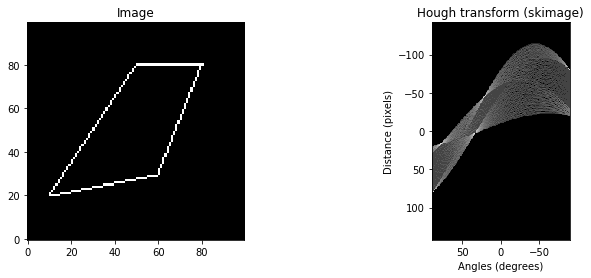

In [2]:
from skimage.transform import hough_line
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

steps = lambda p,q : max(map(lambda x,y: abs(x-y), p, q))+1
coords = lambda p,q,s : tuple([np.linspace(x,y,s,dtype=np.uint16) for x,y in zip(p,q)])

def point(img, p):
    "Insert a point in the black/white image at position p"
    img[p] = 1

def line(img, p, q):
    "Insert a line from p to q in the black/white image"
    img[coords(p,q,steps(p,q))] = 1

def polygon(img, vertices):
    "Insert a (closed) polygon given by a list of points into the black/white image"
    for p, q in zip(vertices, vertices[1:]+vertices[0:1]):
        line(img,p,q)

img = np.zeros((100,100))

polygon(img,[(20,10),(80,50),(80,80),(30,60)])


plt.figure(figsize=(12, 4))
plt.gray()
plt.subplot(1,2,1) ; plt.title('Image'); plt.imshow(img, origin = 'lower')

out, angles, d = hough_line(img)
plt.subplot(1,2,2) ; plt.title('Hough transform (skimage)');
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')
plt.imshow(np.log(1 + out), extent=[np.rad2deg(angles[-1]), np.rad2deg(angles[0]), d[-1], d[0]], origin = 'lower')

## Assignment 2: Implementing Hough transform [7 Points]

**a)** Implement your own version of linear Hough transform and compare the results with the function `skimage.transform.hough_line`.

TypeError: 'numpy.dtype' object is not callable

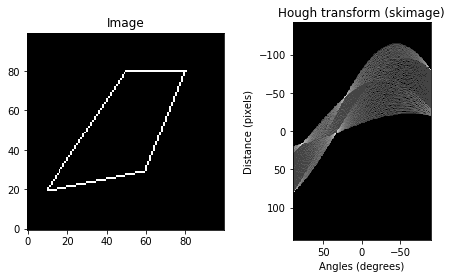

In [3]:
from skimage.transform import hough_line
from skimage import filters
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
import warnings
warnings.filterwarnings('ignore')

def my_hough_line(img, angles=180):
    """
    Apply linear Hough transform to the given image.
    
    Arguments:
        img: numpy.ndarray
            The binary image to transform
        angles: int
            The number of angles to consider.
    Result:
        accumulator: numpy.ndarray
            The accumulator space.
    """
    # indices of edge pixels found with sobel filter
    edge_idx = np.transpose(np.nonzero(filters.sobel(img)))
    edge_idx = np.ma.make_mask(edge_idx).dtype(np.int8
    
    # image dimensions
    width, height = img.shape
    diag_len = int(np.ceil(np.linalg.norm([width, height])))
    
    # angles in radians
    thetas = np.deg2rad(np.arange(-angles//2, angles//2))
    # cached values
    theta_cache = list(zip(np.cos(thetas), np.sin(thetas)))
    
    # hough transform accumulator space
    accumulator = np.zeros((2*diag_len, len(thetas)), dtype=np.uint64)
    
    for (x,y) in edge_idx:
        for idx, (cos_t, sin_t) in enumerate(theta_cache):
            #cos_t, sin_t = value
            rho = int(np.round(x*cos_t + y*sin_t) + diag_len)
            accumulator[rho, idx] += 1    

    return accumulator

img = np.zeros((100,100))

# You may try different paintings here:
#point(img, (10,10))
#line(img,(10,20),(70,20))
polygon(img,[(20,10),(80,50),(80,80),(30,60)])

plt.figure(figsize=(12, 4))
plt.gray()
plt.subplot(1,3,1) ; plt.title('Image'); plt.imshow(img, origin = 'lower')

out, angles, d = hough_line(img)
plt.subplot(1,3,2) ; plt.title('Hough transform (skimage)');
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')
plt.imshow(np.log(1 + out), extent=[np.rad2deg(angles[-1]), np.rad2deg(angles[0]), d[-1], d[0]], origin = 'lower')

my_out = my_hough_line(img)
plt.subplot(1,3,3) ; plt.title('Hough transform (own implementation)');
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')
plt.imshow(np.log(1+my_out), extent=[0, 180, -144, 144])
plt.show()

**b)** Under which conditions is (linear) Hough transform invertible? Try to implement an inverse linear Hough transform.

YOUR ANSWER HERE

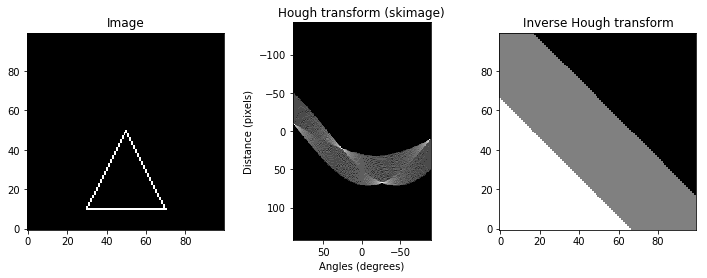

In [72]:
from skimage.transform import hough_line
import matplotlib.pyplot as plt
import numpy as np


# YOUR CODE HERE

def my_inverse_hough_line(accumulator, shape):
    """Compute an inverse Hough transform, i.e. compute the image from the accumulator space.
    
    Arguments:
        accumulator: numpy.ndarray
        shape: tuple
            The shape (dimensions) of the image to be created

    Result:
        img: numpy.ndarray
            The image created from the accumulator space.
    """
    img = np.zeros(shape, np.uint64)
    
    # YOUR CODE HERE
    
    threshold = accumulator.max()-5
    
    rhos, thetas = np.transpose(np.argwhere(accumulator > threshold)).astype(np.float32)
    
    rhos -= rhos.max()/2
    thetas -= thetas.max()/2 
    
    thetas = np.deg2rad(thetas)
    
    theta_cache = zip(np.cos(thetas), np.sin(thetas))
    
    for idx, (cos_t, sin_t) in enumerate(theta_cache):
        r = rhos[idx]
        for (x,y) in np.ndindex(img.shape):
            if (x*cos_t + y*cos_t) - r < 0.1:
                img[x,y] += 1
    return img

img = np.zeros((100,100))

#point(img, (10,10))
#line(img,(10,20),(70,20))
#line(img,(20,10),(20,70))
polygon(img,[(10,30),(50,50),(10,70)])

plt.figure(figsize=(12, 4))
plt.gray()
plt.subplot(1,3,1) ; plt.title('Image'); plt.imshow(img, origin = 'lower')

out, angles, d = hough_line(img)
plt.subplot(1,3,2) ; plt.title('Hough transform (skimage)');
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')
plt.imshow(np.log(1 + out), extent=[np.rad2deg(angles[-1]), np.rad2deg(angles[0]), d[-1], d[0]])

img2 = my_inverse_hough_line(out, img.shape)
plt.subplot(1,3,3) ; plt.title('Inverse Hough transform');
plt.imshow(img2, origin = 'lower')
plt.show()

## Assignment 3: Circular Hough [7 Points]

**a)** Explain the idea of circular Hough transform. How many dimensions does the accumulator space have and what do they represent? What practical problems do you expect when computing circular Hough transform?

YOUR ANSWER HERE

**b)** Now implement circular hough transform. First think how the accumulator space should be represented. You may provide an additional parameter to only look for circles of a given radius (or a range of radii). Then apply it to the image `xmas.png` to detect the balls. Mark them in the original image. (Bonus task: also detect the presents using linear Hough transform).

In [ ]:
from skimage.transform import hough_line
from scipy import misc
import matplotlib.pyplot as plt
import numpy as np

# load the image
img = plt.imread('images/xmas.png')

# YOUR CODE HERE

## Assignment 4: Application: Eye detection [Bonus]

**Bonus:** If you do this exercise, you may leave out one of the others.

**a)** It was suggested in the lecture, that circular Hough transform can be used to implement a simple
form of “eye tracking”. Try this using your webcam.

Hints:
* You may start with a single snapshot (or some other image of a face from wherever you like) before applying your function to a video stream.
* You may start using functions like `hough_circle` from `skimage.transform`, which implement circular Hough transform.
* You may try to apply some preprocessing to detect edges or regions prior to Hough transform (you may use anything you know from the lecture).
* `hough_circle` may be inappropriate, as it is designed to detect full circles, while eyes are often partially occluded. You may implement your own Hough transforms, which detects this kind of incomplete circles.
* You may apply additional knowledge to detect eyes, e.g. that they usually occur in pairs. You may also use the approximate size and position from last frame.

In [ ]:
import cv2
import numpy as np
from cvloop import cvloop

# Depending on your webcam you might need to adapt parameters, to make
# the solution work on your machine.



def detect_eyes(img):
    """Find pairs of eyes in image based on circular Hough transform.
    
    Args:
        img (ndarray): The RGB input image to detect the eyes in. shape=(h, w, 3)
        
    Returns:
        ndarray: The image with detected eyes highlighted.
    
    """
    # YOUR CODE HERE

cvl = cvloop(function=detect_eyes)